In [25]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
	.appName("WeatherDataAnalysis") \
	.config("spark.executor.cores", "4") \
	.config("spark.executor.memory", "2g") \
	.config("spark.driver.memory", "2g") \
	.getOrCreate()




In [26]:
file = './ancona_data.csv'
# Read the csv file into a Spark DataFrame
data = spark.read.csv(file, header=True, inferSchema=True)
#data.describe().show()

# Data Preprocessing

In [27]:
data = data.drop('Vegitation(High)', 'Vegitation(Low)', 'code', 'id')

In [28]:
from pyspark.sql.functions import col, count, when
data = data.filter(col('Date') >= '2023-01-01 00:00:00')
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+----+----+----+-----+-----+--------+---------+------------+-------------+-------------+------------+--------+------------------+----+----------------+
|Date| NO2|  O3| PM10|PM2_5|Latitude|Longitude|station_name|Wind-Speed(U)|Wind-Speed(V)|DewpointTemp|SoilTemp|TotalPrecipitation|Temp|RelativeHumidity|
+----+----+----+-----+-----+--------+---------+------------+-------------+-------------+------------+--------+------------------+----+----------------+
|   0|2181|9186|10151|10765|       0|        0|           0|            0|            0|           0|       0|                 0|   0|               0|
+----+----+----+-----+-----+--------+---------+------------+-------------+-------------+------------+--------+------------------+----+----------------+



In [29]:
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+----+----+----+-----+-----+--------+---------+------------+-------------+-------------+------------+--------+------------------+----+----------------+
|Date| NO2|  O3| PM10|PM2_5|Latitude|Longitude|station_name|Wind-Speed(U)|Wind-Speed(V)|DewpointTemp|SoilTemp|TotalPrecipitation|Temp|RelativeHumidity|
+----+----+----+-----+-----+--------+---------+------------+-------------+-------------+------------+--------+------------------+----+----------------+
|   0|2181|9186|10151|10765|       0|        0|           0|            0|            0|           0|       0|                 0|   0|               0|
+----+----+----+-----+-----+--------+---------+------------+-------------+-------------+------------+--------+------------------+----+----------------+



In [30]:
from pyspark.sql.functions import mean, col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import avg

null_columns = ['NO2', 'O3', 'PM10', 'PM2_5']
train_coloumns = ['Date', 'PM2_5', 'NO2', 'O3', 'PM10', 'Temp','RelativeHumidity','TotalPrecipitation', 'Wind-Speed(U)', 'Wind-Speed(V)']




In [31]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import col, mean
import pandas as pd
import numpy as np

# Define interpolation function for specific columns
def interpolate_nulls(group_pd):
    # Sort by date
    group_pd = group_pd.sort_values('Date')
    # Set Date as index
    group_pd.set_index('Date', inplace=True)
    
    # Interpolate null_columns with linear method first
    group_pd[null_columns] = group_pd[null_columns].interpolate(method='linear', limit_direction='both')
    
    # For any remaining NaN values (at the start or end), use forward and backward fill
    group_pd[null_columns] = group_pd[null_columns].ffill()
    group_pd[null_columns] = group_pd[null_columns].bfill()
    
    # If there are still NaN values (in case of completely empty columns), 
    # fill with column means or zeros
    for col in null_columns:
        if group_pd[col].isnull().any():
            col_mean = group_pd[col].mean()
            if np.isnan(col_mean):  # If column is completely empty
                group_pd[col] = group_pd[col].fillna(0)
            else:
                group_pd[col] = group_pd[col].fillna(col_mean)
    
    # Reset index
    group_pd.reset_index(inplace=True)
    return group_pd

# Schema for the output DataFrame
output_schema = data.schema

# Apply interpolation by station
data_filled = data.groupby('station_name').applyInPandas(interpolate_nulls, schema=output_schema)

# Sort the results
data_filled = data_filled.orderBy('station_name', 'Date')

# Verify the results by checking null counts after interpolation
null_counts_after = data_filled.select([count(when(col(c).isNull(), c)).alias(c) for c in null_columns])
print("Null counts after interpolation:")
null_counts_after.show()

Null counts after interpolation:
+---+---+----+-----+
|NO2| O3|PM10|PM2_5|
+---+---+----+-----+
|  0|  0|   0|    0|
+---+---+----+-----+



# EDA

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import plotly.express as px
from folium.plugins import HeatMap


data_geo = data_filled.toPandas()
# 提取日期
data_geo['date'] = data_geo['Date'].dt.date
daily_max = data_geo.groupby(['date', 'station_name'])['PM2_5'].max().reset_index()

# Select the top 10 highest daily PM2.5 values per station and compute their average
top10_daily_max = daily_max.groupby('station_name', group_keys=False).apply(lambda x: x.nlargest(100, 'PM2_5')).reset_index(drop=True)
station_daily_max_avg = top10_daily_max.groupby('station_name')['PM2_5'].mean().reset_index()

# 获取每个 station_name 唯一的经纬度
station_coords = data_geo[['station_name', 'Latitude', 'Longitude']].drop_duplicates()

# 将经纬度合并回 daily_avg
data1 = station_daily_max_avg.merge(station_coords, on='station_name', how='left')

# 重命名 'PM2_5' 为 'PM2.5' 以便于可视化
data1 = data1.rename(columns={'PM2_5': 'PM2.5'})

# 去除 PM2.5 为空的行
data1 = data1.dropna(subset=['PM2.5'])

# 创建 Plotly 密度地图
fig = px.density_mapbox(
    data1, 
    lat='Latitude', 
    lon='Longitude', 
    z='PM2.5', 
    radius=20, 
    center=dict(lat=data1['Latitude'].mean(), lon=data1['Longitude'].mean()), 
    zoom=8, 
    mapbox_style="open-street-map", 
    title='PM2.5 Density Map with Station Respectly', 
    width=400,
    height=400,
    hover_data={'station_name': True}
)
fig.show()

m = folium.Map(location=[data1['Latitude'].mean(), data1['Longitude'].mean()], zoom_start=8)

heat_data = data1[['Latitude', 'Longitude', 'PM2.5']].values.tolist()
HeatMap(heat_data, radius=20).add_to(m)

m


/var/folders/ws/z3gzxp294yx1zqpcs8lmcd7h0000gn/T/ipykernel_50450/3589723515.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



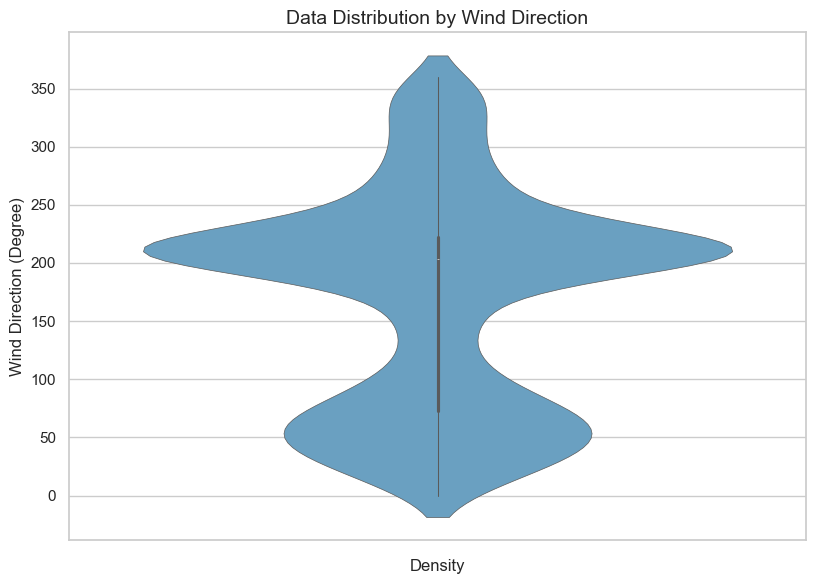

In [37]:
from pyspark.sql.functions import atan2, sqrt, degrees, when
import seaborn as sns


data = data.withColumn("WindSpeed", sqrt(data["Wind-Speed(U)"]**2 + data["Wind-Speed(V)"]**2))

# 计算风向（转换为气象角度）
data = data.withColumn("WindDirection", (degrees(atan2(data["Wind-Speed(U)"], data["Wind-Speed(V)"])) + 360) % 360)

import matplotlib.pyplot as plt

# Convert Spark DataFrame to pandas for analysis and visualization
wind_data = data.toPandas()

plt.figure(figsize=(12, 6))
sns.violinplot(y='WindDirection', data=wind_data, color='#5ba3d0', bw_method=0.2, cut=1, linewidth=.5)
plt.title('Data Distribution by Wind Direction', fontsize=14) 
plt.ylabel('Wind Direction (Degree)', fontsize=12)
plt.xlabel('Density', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gcf().set_size_inches(8, 6)
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium

# 使用每个station每日最大PM2.5值和经纬度进行聚类并在地图上可视化


# 假设 data1 已经存在，包含 'station_name'，'PM2.5'，'Latitude'，'Longitude' 列

# 提取用于聚类的特征
features = ['Latitude', 'Longitude', 'PM2.5']
X = data1[features].values

# 对特征进行标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 选择聚类的数量
n_clusters = 6  # 您可以根据需要调整聚类数

# 进行 KMeans 聚类
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# 将聚类结果添加到 data1
data1['Cluster'] = kmeans.labels_

# 可视化聚类结果
# 计算地图的中心位置
center_lat = data1['Latitude'].mean()
center_lon = data1['Longitude'].mean()

# 创建 Folium 地图
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# 定义每个聚类的颜色
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred']

# 在地图上添加站点标记
for idx, row in data1.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        popup=(f"Station: {row['station_name']}<br>"
               f"Average PM2.5: {row['PM2.5']:.2f}<br>"
               f"Cluster: {row['Cluster']}"),
        color=colors[row['Cluster'] % len(colors)],
        fill=True,
        fill_color=colors[row['Cluster'] % len(colors)],
    ).add_to(m)

# 显示地图
m

In [11]:
from pyspark.sql.functions import col
from pyspark.sql.functions import avg

# 筛选 station_name 为指定值的数据

selected_station = ['Ancona Citadella', 'Chiarvalle Average', 'Jesi', 'Chiarvalle', 'Ancona Stazione FF', 'Falconara Scuola']
data_filled = data_filled.filter(col('station_name').isin(selected_station))


In [12]:
# 训练数据标准化
# Features to be standardized
features = ['NO2', 'O3', 'PM10', 'Temp', 'RelativeHumidity', 'TotalPrecipitation', 'Wind-Speed(U)', 'Wind-Speed(V)']

# Create vector assembler
assembler = VectorAssembler(inputCols=features, outputCol='features')
average = assembler.transform(data_filled)

# Apply standardization
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=True, withStd=True)
scalerModel = scaler.fit(average)
average_scaled = scalerModel.transform(average)

# Convert the scaled features back to individual columns
average_scaled = average_scaled.withColumn('scaledFeaturesArray', vector_to_array('scaledFeatures'))
for i, c in enumerate(features):
    average_scaled = average_scaled.withColumn(f'{c}_scaled', col('scaledFeaturesArray')[i])

# Drop temporary columns
average_scaled = average_scaled.drop('features', 'scaledFeatures', 'scaledFeaturesArray')

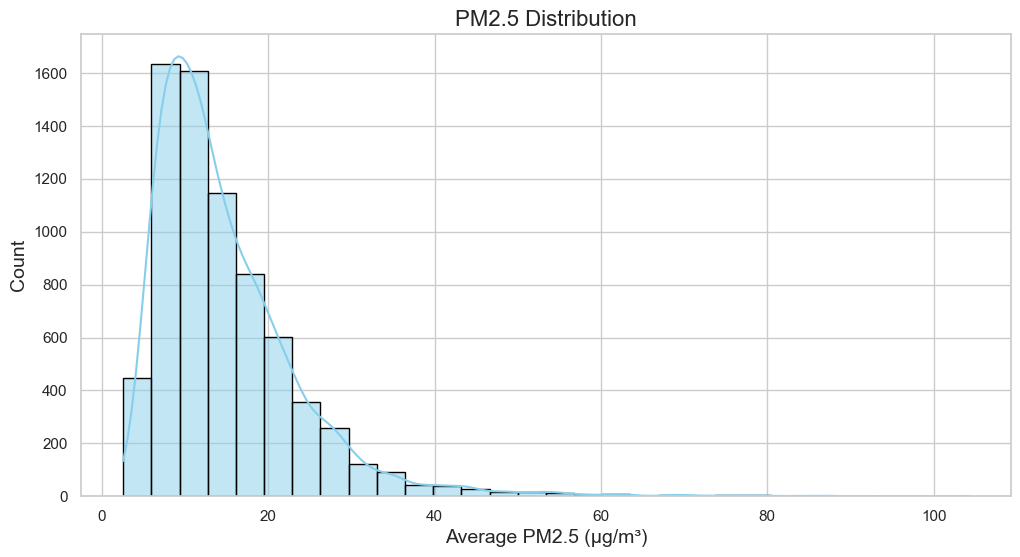

In [13]:
import seaborn as sns

# 转换 Spark DataFrame 为 Pandas DataFrame
# 计算同一时间的各个站点PM2_5平均值
average_PM25 = data_filled.groupBy('Date').agg(avg('PM2_5').alias('PM2_5_avg'))
average_PM25 = average_PM25.orderBy('Date')
average_PM25_pd = average_PM25.toPandas()

# 导入必要的绘图库
import matplotlib.pyplot as plt

# 设置绘图风格
sns.set(style="whitegrid")

# 创建画布
plt.figure(figsize=(12, 6))

# 绘制直方图和核密度估计（KDE）
sns.histplot(
    data=average_PM25_pd,
    x='PM2_5_avg',
    bins=30,             # 直方图的箱数，可以根据需要调整
    kde=True,            # 是否叠加核密度估计
    color='skyblue',     # 直方图的颜色
    edgecolor='black'    # 直方图边缘的颜色
)

# 设置标题和轴标签
plt.title('PM2.5 Distribution', fontsize=16)
plt.xlabel('Average PM2.5 (µg/m³)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# 显示图表
plt.show()

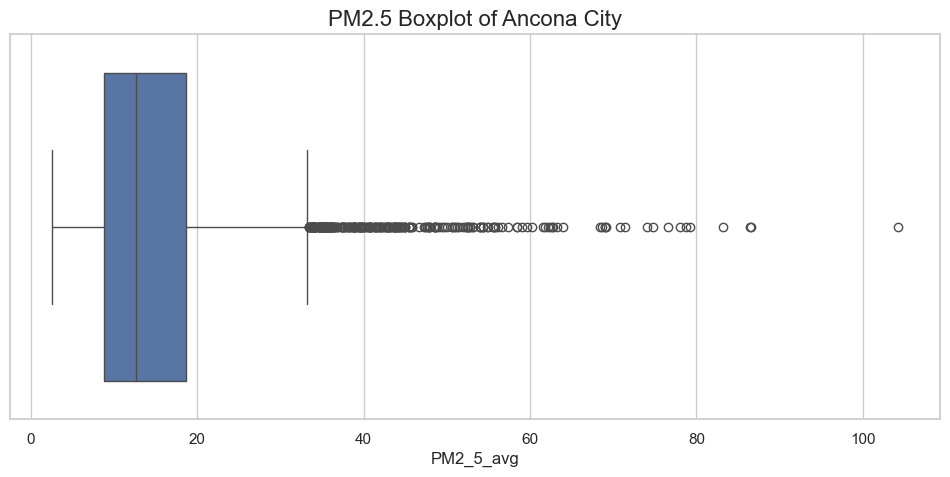

In [14]:
plt.figure(figsize=(12,5))
sns.boxplot(x=average_PM25_pd['PM2_5_avg'])
plt.title('PM2.5 Boxplot of Ancona City', fontsize=16)
plt.show()

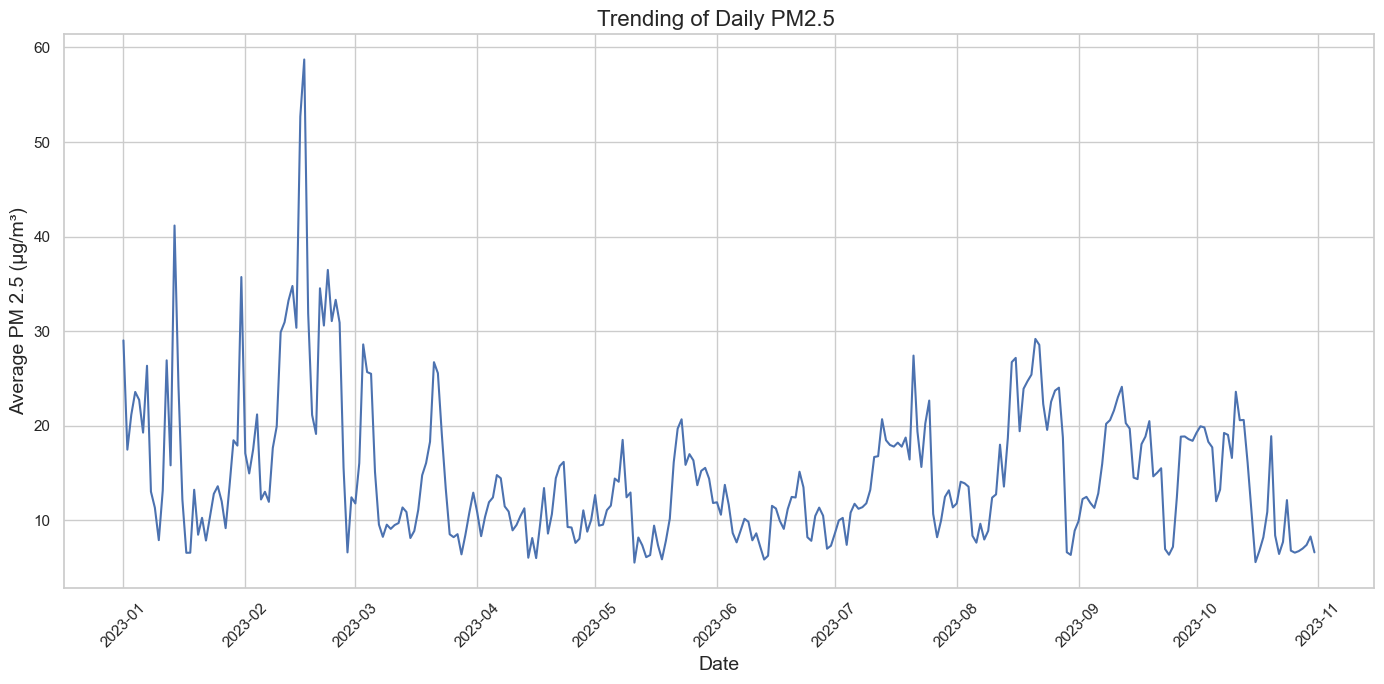

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, avg
# 将 PySpark DataFrame 转换为 Pandas DataFrame

daily_avg_PM25 = data_filled.groupBy(to_date(col("Date")).alias("Date")) \
                         .agg(avg("PM2_5").alias("PM2_5_avg")).orderBy("Date")
daily_avg_pd = daily_avg_PM25.toPandas()

# 确保 'Date' 列为日期时间格式
daily_avg_pd['Date'] = pd.to_datetime(daily_avg_pd['Date'])

# 按日期排序
daily_avg_pd = daily_avg_pd.sort_values('Date')

# 设置绘图大小
plt.figure(figsize=(14, 7))

# 绘制折线图
plt.plot(daily_avg_pd['Date'], daily_avg_pd['PM2_5_avg'], linestyle='-', color='b')

# 添加标题和标签
plt.title('Trending of Daily PM2.5 ', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average PM 2.5 (µg/m³)', fontsize=14)

# 格式化x轴日期显示
plt.xticks(rotation=45)
plt.grid(True)

# 确保布局紧凑
plt.tight_layout()

# 显示图表
plt.show()

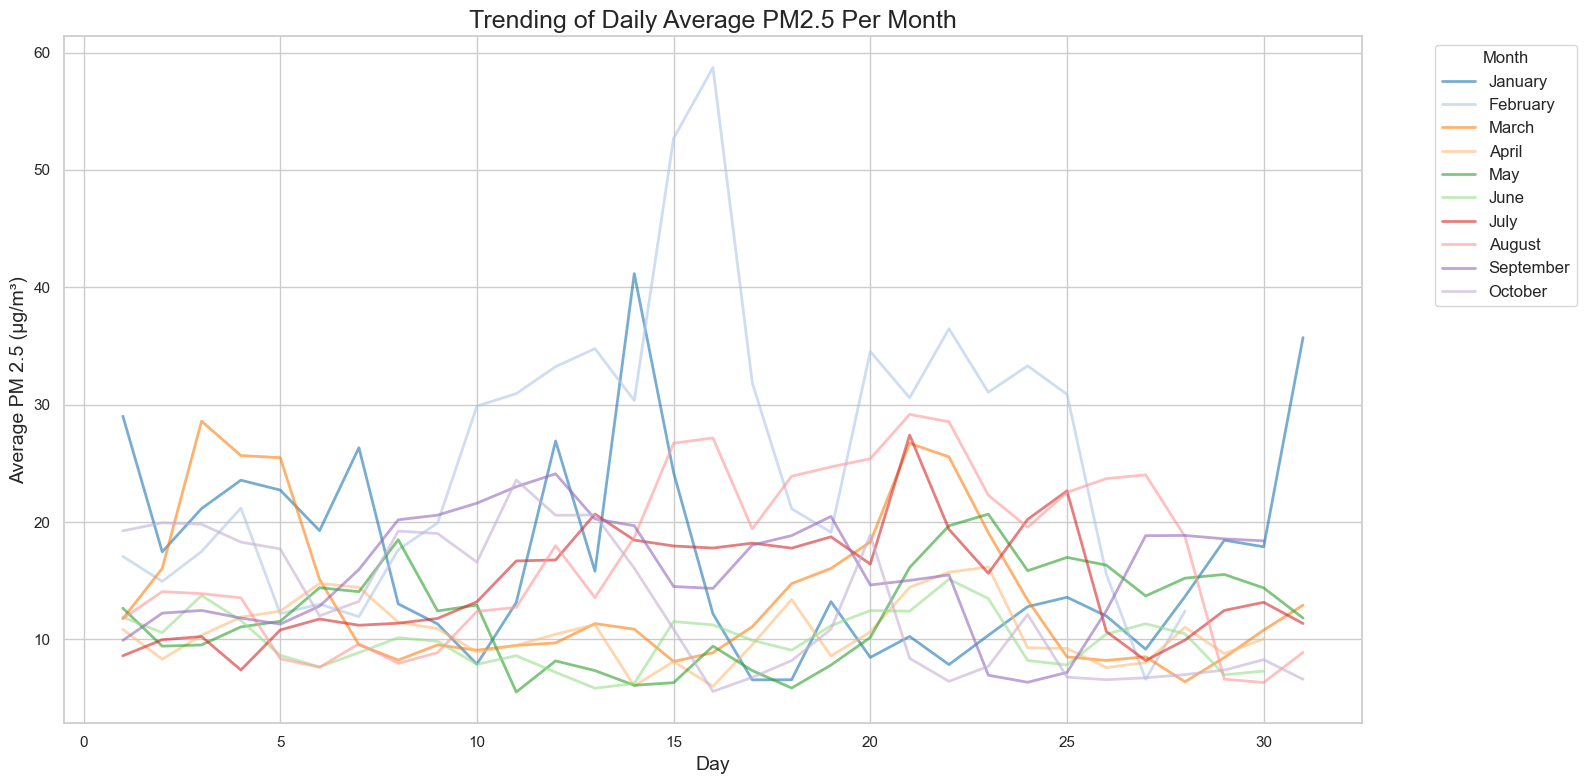

In [16]:
import seaborn as sns

import matplotlib.pyplot as plt

if not isinstance(daily_avg_pd.index, pd.DatetimeIndex):
    daily_avg_pd['Date'] = pd.to_datetime(daily_avg_pd['Date'])
    daily_avg_pd.set_index('Date', inplace=True)

# 提取月份名称和日期（天数）
daily_avg_pd['Month'] = daily_avg_pd.index.month_name()
daily_avg_pd['Day'] = daily_avg_pd.index.day

# 设置绘图风格
plt.figure(figsize=(16, 8))

# 绘制折线图，按月份叠加
sns.lineplot(
    data=daily_avg_pd,
    x='Day',
    y='PM2_5_avg',
    hue='Month',
    palette='tab20',  # 可以根据需要调整调色板
    alpha=0.6,        # 设置透明度以便更好地展示叠加效果
    linewidth=2
)

# 图表标题和标签
plt.title('Trending of Daily Average PM2.5 Per Month', fontsize=18)
plt.xlabel('Day', fontsize=14)
plt.ylabel('Average PM 2.5 (µg/m³)', fontsize=14)

# 调整图例位置
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# 显示图表
plt.tight_layout()
plt.show()

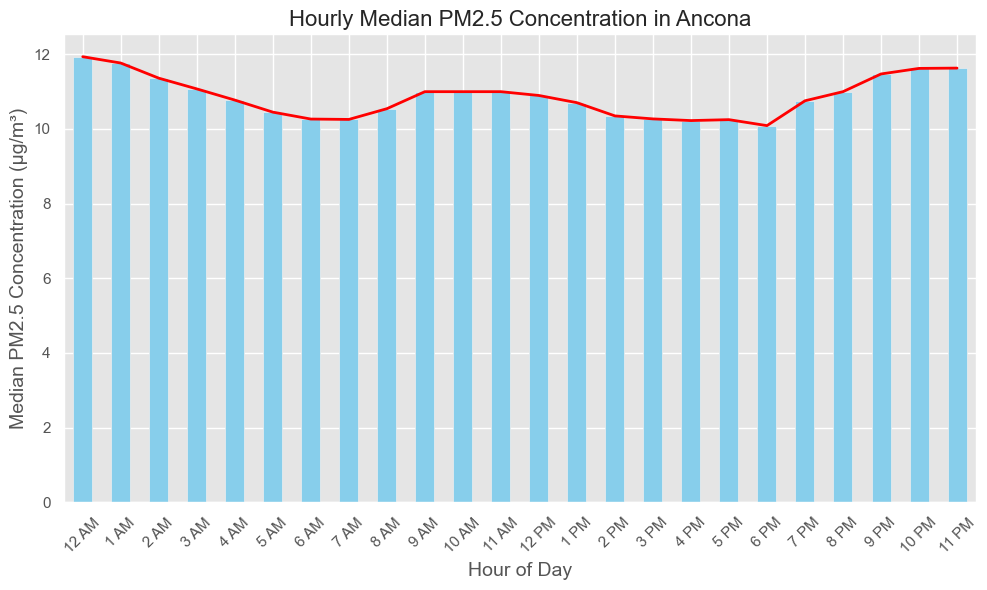

In [17]:
from pyspark.sql.functions import col, hour, percentile_approx
import pandas as pd

import matplotlib.pyplot as plt

# 从 'Date' 列提取小时
data_with_hour = data.withColumn('hour', hour(col('Date')))

# 计算每小时的 PM2.5 中位数
hourly_median = data_with_hour.groupBy('hour').agg(percentile_approx('PM2_5', 0.5).alias('PM2_5_median'))

# 将结果转换为 Pandas DataFrame 并按照小时排序
hourly_median_pd = hourly_median.toPandas()
hourly_median_pd = hourly_median_pd.sort_values('hour')

# 创建小时标签映射
hrs = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM',
    '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM',
    '8 PM', '9 PM', '10 PM', '11 PM']
hour_dict = {i: hr for i, hr in enumerate(hrs)}

# 映射小时标签
hourly_median_pd['hour_label'] = hourly_median_pd['hour'].map(hour_dict)

# 设置索引为小时标签
hourly_median_pd.set_index('hour_label', inplace=True)

# 绘制每小时 PM2.5 中位数的变化趋势图
with plt.style.context('ggplot'):
    plt.figure(figsize=(10, 6))
    hourly_median_pd['PM2_5_median'].plot(kind='bar', color='skyblue')
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Median PM2.5 Concentration (µg/m³)', fontsize=14)
    plt.title('Hourly Median PM2.5 Concentration in Ancona', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # 在柱状图上绘制趋势折线
    ax = plt.gca()
    x = range(len(hourly_median_pd))
    ax.plot(x, hourly_median_pd['PM2_5_median'], color='red', linewidth=2)
    plt.show()

In [18]:
from pyspark.sql.functions import avg
data_train = data_filled.drop('station_name', 'Latitude', 'Longitude')
# 对同一时间每个站点的各项统计数据取平均值
average_data_filled = data_train.groupBy('Date').agg(
    avg('NO2').alias('avg_NO2'),
    avg('O3').alias('avg_O3'),
    avg('PM10').alias('avg_PM10'),
    avg('PM2_5').alias('avg_PM2_5'),
    avg('Wind-Speed(U)').alias('avg_Wind-Speed(U)'),
    avg('Wind-Speed(V)').alias('avg_Wind-Speed(V)'),
    avg('DewpointTemp').alias('avg_DewpointTemp'),
    avg('SoilTemp').alias('avg_SoilTemp'),
    avg('TotalPrecipitation').alias('avg_TotalPrecipitation'),
    avg('Temp').alias('avg_Temp'),
    avg('RelativeHumidity').alias('avg_RelativeHumidity'),
)
average_data_filled = average_data_filled.orderBy('Date')
# 显示结果
average_data_filled.show()

+-------------------+-------+------+--------+---------+--------------------+--------------------+------------------+------------------+----------------------+------------------+--------------------+
|               Date|avg_NO2|avg_O3|avg_PM10|avg_PM2_5|   avg_Wind-Speed(U)|   avg_Wind-Speed(V)|  avg_DewpointTemp|      avg_SoilTemp|avg_TotalPrecipitation|          avg_Temp|avg_RelativeHumidity|
+-------------------+-------+------+--------+---------+--------------------+--------------------+------------------+------------------+----------------------+------------------+--------------------+
|2023-01-01 00:00:00|   25.4|   7.8|    50.6|     68.6| -0.7692420644669713|  -1.220487529025301| 55.86531735264312| 56.47837942830911|  1.799710990727511...| 56.16425817587693|   97.76204614754741|
|2023-01-01 01:00:00|   21.2|  14.6|    37.2|     58.4| -0.8152434897710737| -1.2328835066157233|55.138913793816585|56.206015626164046|                   0.0|   55.436705487108|   97.75124653093911|
|2023

In [19]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Features to be standardized
features = ['avg_NO2', 'avg_O3', 'avg_PM10', 'avg_Wind-Speed(U)', 'avg_Wind-Speed(V)', 
           'avg_TotalPrecipitation', 'avg_Temp', 'avg_RelativeHumidity', 'avg_DewpointTemp', 'avg_SoilTemp']

# Create vector assembler
assembler = VectorAssembler(inputCols=features, outputCol='features')
average = assembler.transform(average_data_filled)

# Apply standardization
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withMean=True, withStd=True)
scalerModel = scaler.fit(average)
average_scaled = scalerModel.transform(average)

# Convert the scaled features back to individual columns
average_scaled = average_scaled.withColumn('scaledFeaturesArray', vector_to_array('scaledFeatures'))
for i, c in enumerate(features):
    average_scaled = average_scaled.withColumn(f'{c}_scaled', col('scaledFeaturesArray')[i])

# Drop temporary columns
average_scaled = average_scaled.drop('features', 'scaledFeatures', 'scaledFeaturesArray')

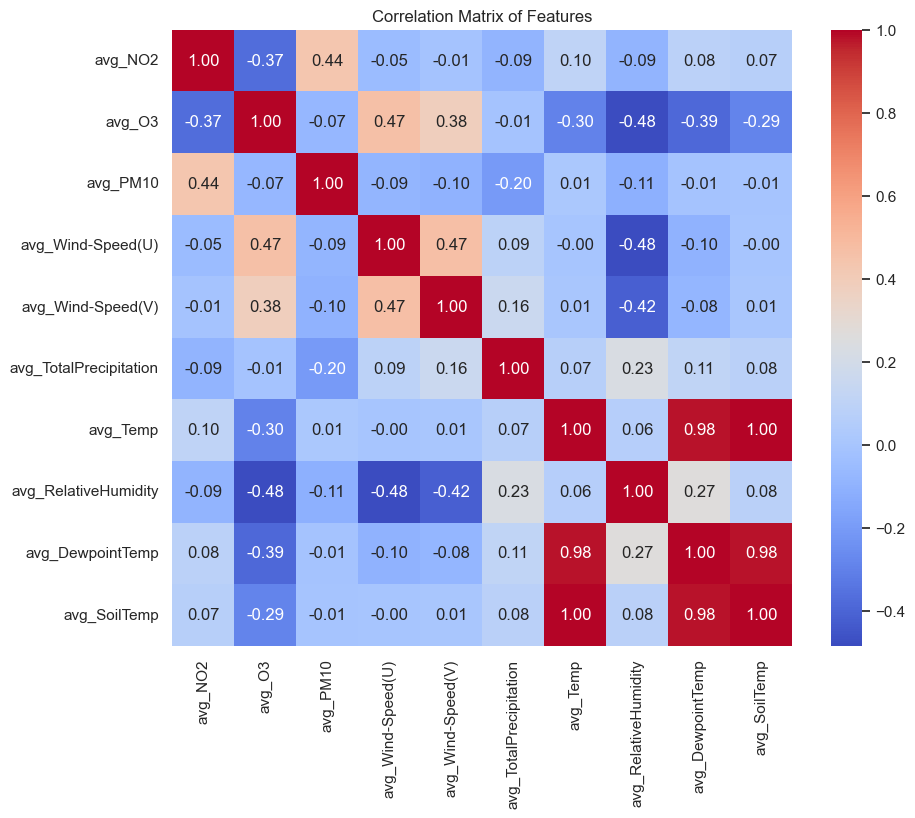

In [20]:
import seaborn as sns

import matplotlib.pyplot as plt


# Select columns that end with '_scaled'
scaled_columns = [c for c in average_scaled.columns if c.endswith('_scaled')]
# Select columns that end with '_scaled'
scaled_columns = [c.replace('_scaled', '') for c in average_scaled.columns if c.endswith('_scaled')]

# Convert to Pandas DataFrame and rename columns without '_scaled' suffix
scaled_pd = average_scaled.select([c for c in average_scaled.columns if c.endswith('_scaled')]).toPandas()
scaled_pd.columns = scaled_columns

# Compute correlation matrix
corr_matrix = scaled_pd.corr()

# Plot heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f") 
plt.title('Correlation Matrix of Features')
plt.show()


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# Calculate VIF for each feature
X = scaled_pd[features]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort VIF values in descending order
vif_data = vif_data.sort_values('VIF', ascending=False)
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
                  Feature          VIF
6                avg_Temp  1195.246565
8        avg_DewpointTemp   791.846587
9            avg_SoilTemp   286.863664
7    avg_RelativeHumidity    34.879155
1                  avg_O3     2.176674
0                 avg_NO2     1.853985
3       avg_Wind-Speed(U)     1.642286
4       avg_Wind-Speed(V)     1.491979
2                avg_PM10     1.358435
5  avg_TotalPrecipitation     1.209590


In [22]:
from pyspark.sql.functions import col

# Drop 'SoilTemp' and 'SoilTemp_scaled' columns
average_scaled = average_scaled.drop('avg_SoilTemp', 'avg_SoilTemp_scaled', 'avg_DewpointTemp', 'avg_DewpointTemp_scaled')

# Model Training and Evaluation


--- Processing Horizon: 1 hour(s) ahead ---


24/12/23 11:02:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Tuning Linear Regression model...
Tuning Decision Tree Regressor model...
Tuning Random Forest Regressor model...


Tuning Gradient Boosted Tree Regressor model...
Evaluating tuned models...
Tuned Linear Regression R²: 0.6758
Tuned Decision Tree Regressor R²: 0.7030
Tuned Random Forest Regressor R²: 0.8206
Tuned Gradient Boosted Tree Regressor R²: 0.7919
Model Weights based on Tuned R²: [0.22591255 0.23501032 0.27433531 0.26474182]

Model RMSE Scores for Horizon 1:
Linear Regression RMSE: 4.8409
Decision Tree RMSE: 4.6333
Random Forest RMSE: 3.6008
Gradient Boosting RMSE: 3.8781
Ensemble Model Tuned R² for Horizon 1: 0.7903
Ensemble Model RMSE: 3.8930



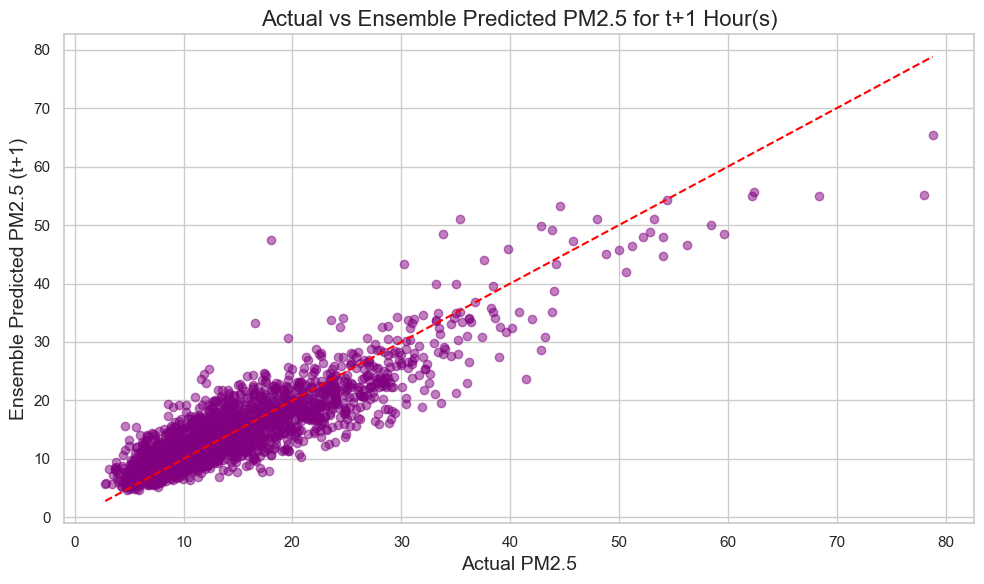


--- Processing Horizon: 2 hour(s) ahead ---
Tuning Linear Regression model...
Tuning Decision Tree Regressor model...
Tuning Random Forest Regressor model...


Tuning Gradient Boosted Tree Regressor model...


Evaluating tuned models...
Tuned Linear Regression R²: 0.6607
Tuned Decision Tree Regressor R²: 0.7091
Tuned Random Forest Regressor R²: 0.7970
Tuned Gradient Boosted Tree Regressor R²: 0.7660
Model Weights based on Tuned R²: [0.2252686  0.24177777 0.27177309 0.26118054]

Model RMSE Scores for Horizon 2:
Linear Regression RMSE: 4.9466
Decision Tree RMSE: 4.5801
Random Forest RMSE: 3.8255
Gradient Boosting RMSE: 4.1079
Ensemble Model Tuned R² for Horizon 2: 0.7778
Ensemble Model RMSE: 4.0026



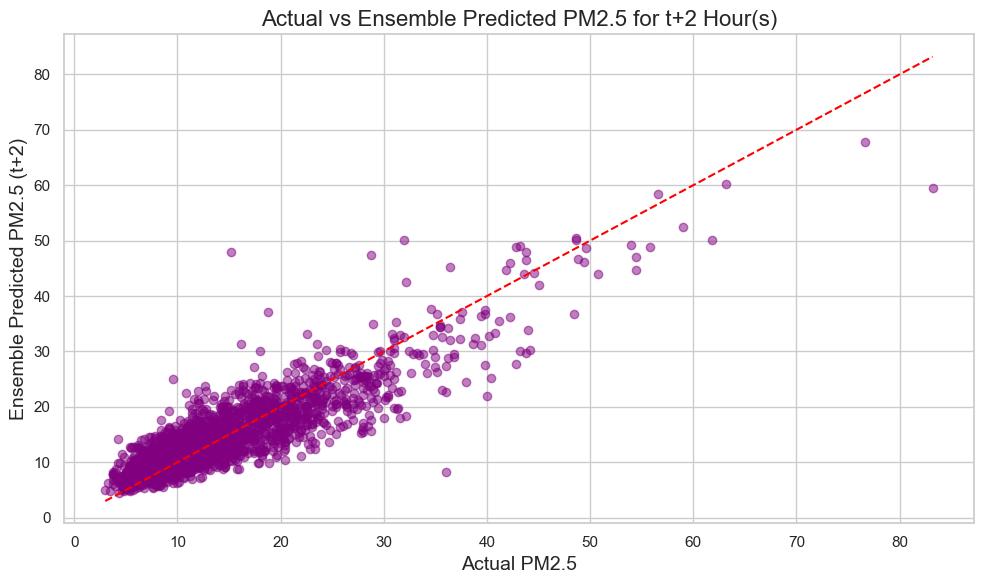


--- Processing Horizon: 3 hour(s) ahead ---
Tuning Linear Regression model...
Tuning Decision Tree Regressor model...
Tuning Random Forest Regressor model...


Tuning Gradient Boosted Tree Regressor model...


Evaluating tuned models...
Tuned Linear Regression R²: 0.6411
Tuned Decision Tree Regressor R²: 0.6763
Tuned Random Forest Regressor R²: 0.7847
Tuned Gradient Boosted Tree Regressor R²: 0.7392
Model Weights based on Tuned R²: [0.22561908 0.23803576 0.27617918 0.26016599]

Model RMSE Scores for Horizon 3:
Linear Regression RMSE: 5.0212
Decision Tree RMSE: 4.7681
Random Forest RMSE: 3.8887
Gradient Boosting RMSE: 4.2799
Ensemble Model Tuned R² for Horizon 3: 0.7590
Ensemble Model RMSE: 4.1147



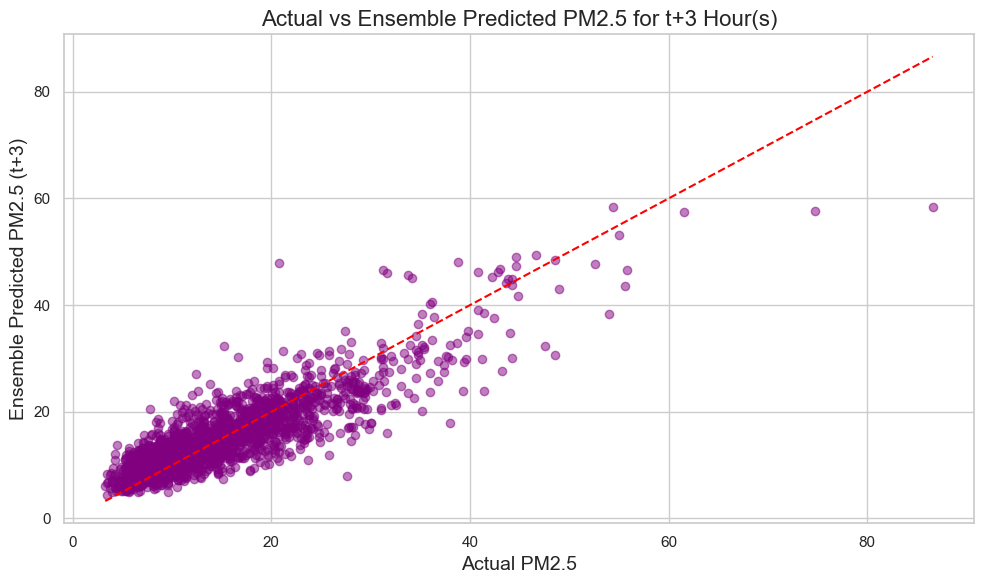


--- Ensemble Model R² Scores for All Horizons ---
Horizon t+1 Hour(s): R² = 0.7903
Horizon t+2 Hour(s): R² = 0.7778
Horizon t+3 Hour(s): R² = 0.7590


In [23]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, lead
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 初始化 Spark 会话
spark = SparkSession.builder \
    .appName("PM2.5_Ensemble_MultiStep_Prediction").config("spark.executor.instances", 4).config("spark.executor.cores", 4).config("spark.driver.memory", "2G").config("spark.executor.memory", "8G").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# 并且包含一个时间戳列 'timestamp'，按升序排序

from pyspark.sql.functions import monotonically_increasing_id, to_timestamp
average_scaled = average_scaled.withColumn("timestamp", to_timestamp("Date"))

# 创建窗口规格，按照时间戳排序
window_spec = Window.orderBy("timestamp")

# 创建未来3小时的 PM2.5 标签列
for i in range(1, 4):
    average_scaled = average_scaled.withColumn(f"avg_PM2_5_t{i}", lead("avg_PM2_5", i).over(window_spec))

# 删除包含任何未来标签的行（即最后3行）
average_scaled = average_scaled.na.drop(subset=[f"avg_PM2_5_t{i}" for i in range(1,4)])

# 定义要预测的时段
horizons = range(1, 4)

# 定义特征列（使用标准化后的数据）

features_cols = ['avg_NO2_scaled', 'avg_O3_scaled', 'avg_PM10_scaled', 'avg_Wind-Speed(U)_scaled', 'avg_Wind-Speed(V)_scaled', 
           'avg_TotalPrecipitation_scaled', 'avg_Temp_scaled', 'avg_RelativeHumidity_scaled']


# 初始化回归评估器
evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName='r2')

# 定义函数进行模型训练与超参数调优
def train_and_tune_model(model, param_grid, train_data, evaluator, num_folds=3):
    
    # 训练并调优模型，返回最佳模型
    
    crossval = CrossValidator(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=num_folds,
        parallelism=4  # 并行度
    )
    cv_model = crossval.fit(train_data)
    return cv_model.bestModel

# 存储各时段的 R² 分数和权重
r2_scores_all = {}
weights_all = {}
ensemble_r2_scores = {}
rmse_scores_all = {}
model_rmse_scores = {}
predictions_all = {}

for horizon in horizons:
    print(f"\n--- Processing Horizon: {horizon} hour(s) ahead ---")
    
    # 定义当前时段的标签列
    label_col = f"avg_PM2_5_t{horizon}"
    
    # 创建 VectorAssembler，将特征列组合成一个特征向量
    assembler = VectorAssembler(inputCols=features_cols, outputCol='features')
    data_prepared = assembler.transform(average_scaled)
    
    # 选择最终用于模型训练的列，并重命名标签列
    data_final = data_prepared.select('features', col(label_col).alias('label'))
    
    # 分割数据集为训练集和测试集
    train_data, test_data = data_final.randomSplit([0.7, 0.3], seed=42)
    
    # 初始化四种回归模型
    lr = LinearRegression(featuresCol='features', labelCol='label')
    dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')
    rf = RandomForestRegressor(featuresCol='features', labelCol='label')
    gbt = GBTRegressor(featuresCol='features', labelCol='label')
    
    # 定义各模型的超参数网格
    # 1. 线性回归超参数网格
    lr_param_grid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()
    
    # 2. 决策树回归器超参数网格
    dt_param_grid = ParamGridBuilder() \
        .addGrid(dt.maxDepth, [5, 10, 15]) \
        .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
        .build()
    
    # 3. 随机森林回归器超参数网格
    rf_param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [50, 100, 200]) \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .build()
    
    # 4. 梯度提升树回归器超参数网格
    gbt_param_grid = ParamGridBuilder() \
        .addGrid(gbt.maxIter, [50, 100, 150]) \
        .addGrid(gbt.maxDepth, [3, 5, 7]) \
        .build()
    
    # 训练并调优每个模型
    print("Tuning Linear Regression model...")
    best_lr = train_and_tune_model(lr, lr_param_grid, train_data, evaluator)
    
    print("Tuning Decision Tree Regressor model...")
    best_dt = train_and_tune_model(dt, dt_param_grid, train_data, evaluator)
    
    print("Tuning Random Forest Regressor model...")
    best_rf = train_and_tune_model(rf, rf_param_grid, train_data, evaluator)
    
    print("Tuning Gradient Boosted Tree Regressor model...")
    best_gbt = train_and_tune_model(gbt, gbt_param_grid, train_data, evaluator)
    
    # 评估每个模型在测试集上的表现
    test_labels = test_data.select('label').toPandas()['label']
    print("Evaluating tuned models...")
    lr_predictions = best_lr.transform(test_data)
    lr_pred = lr_predictions.select('prediction').toPandas()['prediction']
    lr_r2 = evaluator.evaluate(lr_predictions)
    lr_rmse = np.sqrt(mean_squared_error(test_labels, lr_pred))
    
    dt_predictions = best_dt.transform(test_data)
    dt_pred = dt_predictions.select('prediction').toPandas()['prediction']
    dt_r2 = evaluator.evaluate(dt_predictions)
    dt_rmse = np.sqrt(mean_squared_error(test_labels, dt_pred))
    
    rf_predictions = best_rf.transform(test_data)
    rf_pred = rf_predictions.select('prediction').toPandas()['prediction']
    rf_r2 = evaluator.evaluate(rf_predictions)
    rf_rmse = np.sqrt(mean_squared_error(test_labels, rf_pred))
    
    gbt_predictions = best_gbt.transform(test_data)
    gbt_pred = gbt_predictions.select('prediction').toPandas()['prediction']
    gbt_r2 = evaluator.evaluate(gbt_predictions)
    gbt_rmse = np.sqrt(mean_squared_error(test_labels, gbt_pred))
    
    # Store RMSE scores for each model
    model_rmse_scores[horizon] = {
        'Linear Regression': lr_rmse,
        'Decision Tree': dt_rmse,
        'Random Forest': rf_rmse,
        'Gradient Boosting': gbt_rmse
    }
    
    print(f"Tuned Linear Regression R²: {lr_r2:.4f}")
    print(f"Tuned Decision Tree Regressor R²: {dt_r2:.4f}")
    print(f"Tuned Random Forest Regressor R²: {rf_r2:.4f}")
    print(f"Tuned Gradient Boosted Tree Regressor R²: {gbt_r2:.4f}")
    

    # 存储 R² 分数
    r2_scores = np.array([lr_r2, dt_r2, rf_r2, gbt_r2])
    r2_scores_all[horizon] = r2_scores
    
    # 将 R² 转换为权重
    weights = r2_scores / r2_scores.sum()
    weights_all[horizon] = weights
    print(f"Model Weights based on Tuned R²: {weights}")
    
    print(f"\nModel RMSE Scores for Horizon {horizon}:")
    print(f"Linear Regression RMSE: {lr_rmse:.4f}")
    print(f"Decision Tree RMSE: {dt_rmse:.4f}")
    print(f"Random Forest RMSE: {rf_rmse:.4f}")
    print(f"Gradient Boosting RMSE: {gbt_rmse:.4f}")
    # 收集测试集的标签和各模型的预测

    # 构建集成预测
    ensemble_predictions = (
        weights[0] * lr_pred +
        weights[1] * dt_pred +
        weights[2] * rf_pred +
        weights[3] * gbt_pred
    )
    
    # 计算 Ensemble 模型的 R²
    ensemble_r2 = r2_score(test_labels, ensemble_predictions)
    ensemble_r2_scores[horizon] = ensemble_r2
    print(f"Ensemble Model Tuned R² for Horizon {horizon}: {ensemble_r2:.4f}")
    ensemble_rmse = np.sqrt(mean_squared_error(test_labels, ensemble_predictions))
    rmse_scores_all[horizon] = ensemble_rmse
    print(f"Ensemble Model RMSE: {ensemble_rmse:.4f}\n")
    
    # 可视化 Ensemble 预测与实际值的对比
    plt.figure(figsize=(10,6))
    plt.scatter(test_labels, ensemble_predictions, alpha=0.5, color='purple')
    plt.xlabel('Actual PM2.5', fontsize=14)
    plt.ylabel(f'Ensemble Predicted PM2.5 (t+{horizon})', fontsize=14)
    plt.title(f'Actual vs Ensemble Predicted PM2.5 for t+{horizon} Hour(s)', fontsize=16)
    plt.plot([test_labels.min(), test_labels.max()], 
             [test_labels.min(), test_labels.max()], 
             color='red', linestyle='--')
    plt.tight_layout()
    plt.show()
    

    predictions_all[horizon] = ensemble_predictions

# 打印所有时段的 Ensemble R² 分数
print("\n--- Ensemble Model R² Scores for All Horizons ---")
for horizon in horizons:
    print(f"Horizon t+{horizon} Hour(s): R² = {ensemble_r2_scores[horizon]:.4f}")


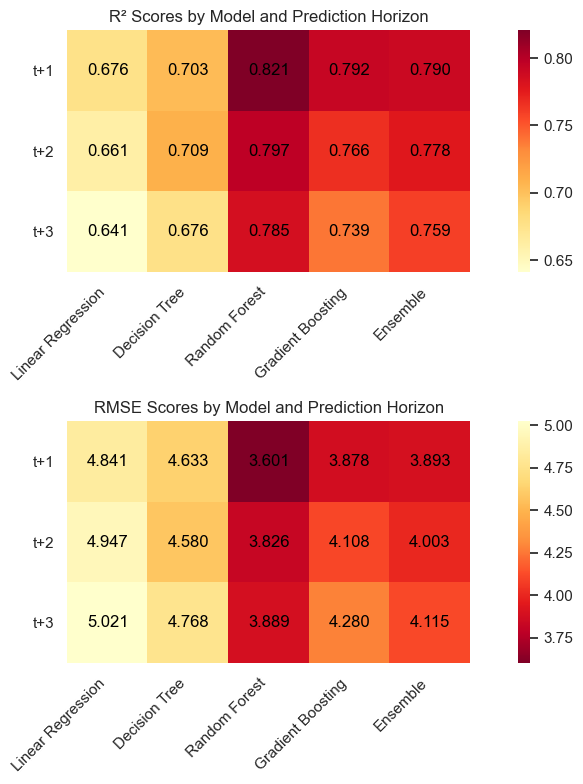


Performance Summary:
--------------------------------------------------------------------------------
 Horizon  |          Model          |      R²       |     RMSE      
--------------------------------------------------------------------------------
t+   1    |    Linear Regression    |     0.676     |     4.841     
t+   1    |      Decision Tree      |     0.703     |     4.633     
t+   1    |      Random Forest      |     0.821     |     3.601     
t+   1    |    Gradient Boosting    |     0.792     |     3.878     
t+   1    |        Ensemble         |     0.790     |     3.893     
--------------------------------------------------------------------------------
t+   2    |    Linear Regression    |     0.661     |     4.947     
t+   2    |      Decision Tree      |     0.709     |     4.580     
t+   2    |      Random Forest      |     0.797     |     3.826     
t+   2    |    Gradient Boosting    |     0.766     |     4.108     
t+   2    |        Ensemble         |     0.7

In [47]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create figure with subplots for R² scores and RMSE scores
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot R² scores
horizons = [1, 2, 3] 
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Ensemble']

# Prepare data for plotting R² scores
r2_data = []
for h in horizons:
    scores = list(r2_scores_all[h]) + [ensemble_r2_scores[h]]
    r2_data.append(scores)

r2_data = np.array(r2_data)

# Plot R² scores
im1 = ax1.imshow(r2_data, cmap='YlOrRd')
ax1.set_xticks(range(len(model_names)))
ax1.set_yticks(range(len(horizons)))
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.set_yticklabels([f't+{h}' for h in horizons])
ax1.set_title('R² Scores by Model and Prediction Horizon')
ax1.grid(False)
# Add colorbar without grid lines
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.outline.set_visible(False)
cbar1.solids.set_rasterized(True) 
# Add text annotations to the R² heatmap
for i in range(len(horizons)):
    for j in range(len(model_names)):
        text = ax1.text(j, i, f'{r2_data[i, j]:.3f}',
                       ha="center", va="center", color="black")

# Plot RMSE scores
rmse_data = []
for h in horizons:
    rmse_scores = [
        model_rmse_scores[h]['Linear Regression'],
        model_rmse_scores[h]['Decision Tree'],
        model_rmse_scores[h]['Random Forest'],
        model_rmse_scores[h]['Gradient Boosting'],
        rmse_scores_all[h]
    ]
    rmse_data.append(rmse_scores)

rmse_data = np.array(rmse_data)

# Plot RMSE scores
im2 = ax2.imshow(rmse_data, cmap='YlOrRd_r')  
ax2.set_xticks(range(len(model_names)))
ax2.set_yticks(range(len(horizons)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_yticklabels([f't+{h}' for h in horizons])
ax2.set_title('RMSE Scores by Model and Prediction Horizon')
ax2.grid(False)
# Add colorbar without grid lines
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.outline.set_visible(False)

# Add text annotations to the RMSE heatmap
for i in range(len(horizons)):
    for j in range(len(model_names)):
        text = ax2.text(j, i, f'{rmse_data[i, j]:.3f}',
                       ha="center", va="center", color="black")

# Hide axes spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# Create a summary table of performance metrics
print("\nPerformance Summary:")
print("-" * 80)
print(f"{'Horizon':^10}|{'Model':^25}|{'R²':^15}|{'RMSE':^15}")
print("-" * 80)

for h in horizons:
    for i, model in enumerate(model_names):
        if model != 'Ensemble':
            r2 = r2_scores_all[h][i]
            rmse = model_rmse_scores[h][model]
        else:
            r2 = ensemble_r2_scores[h]
            rmse = rmse_scores_all[h]
        print(f"t+{h:^8}|{model:^25}|{r2:^15.3f}|{rmse:^15.3f}")
    print("-" * 80)

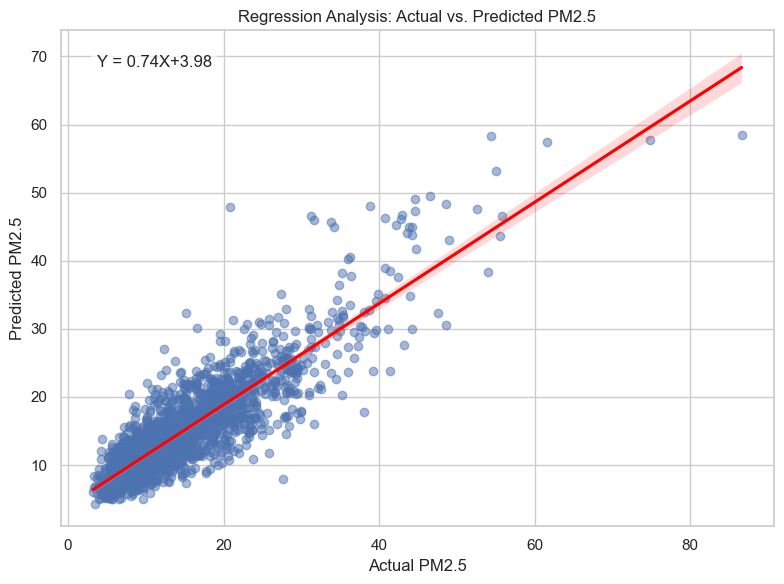

In [58]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# 将实际值和预测值组合为 DataFrame
df_reg = pd.DataFrame({
    'Actual': test_labels,         # 测试集真实PM2.5
    'Predicted': ensemble_predictions  # 集成模型预测PM2.5
})

plt.figure(figsize=(8,6))
# 绘制散点图与回归线
sns.regplot(x='Actual', y='Predicted', data=df_reg, 
            scatter_kws={'alpha':0.5},   # 散点透明度
            line_kws={'color':'red'})    # 回归线颜色
plt.title("Regression Analysis: Actual vs. Predicted PM2.5")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
slope, intercept = np.polyfit(df_reg['Actual'], df_reg['Predicted'], 1)
plt.text(
    0.05, 0.95, 
    f"Y = {slope:.2f}X+{intercept:.2f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
    verticalalignment='top'
)

plt.tight_layout()
plt.show()


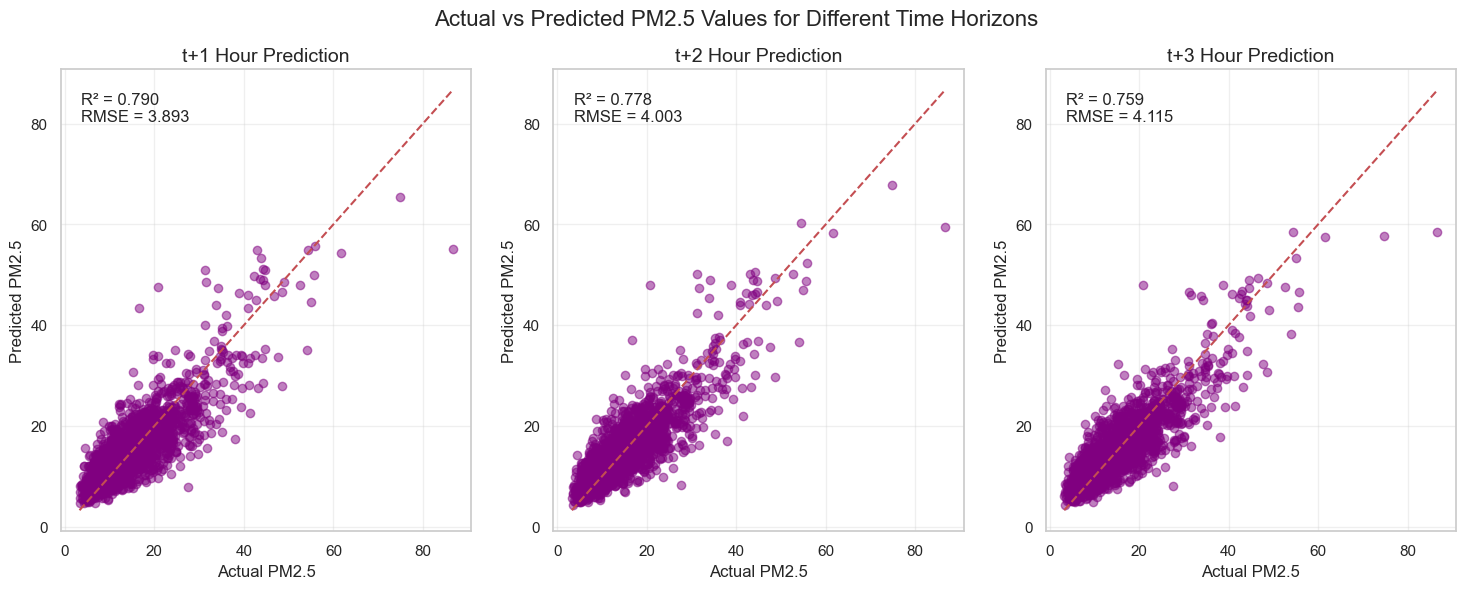

<Figure size 640x480 with 0 Axes>

Residual Mean: -0.2107469185077296
Residual Std Dev: 4.110284971486237


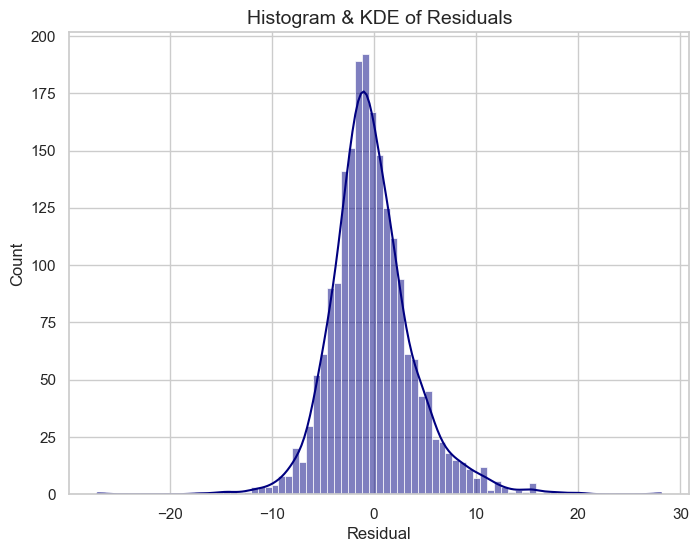

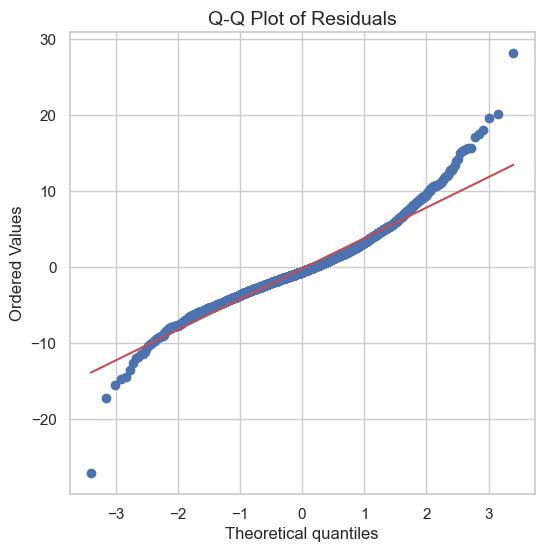

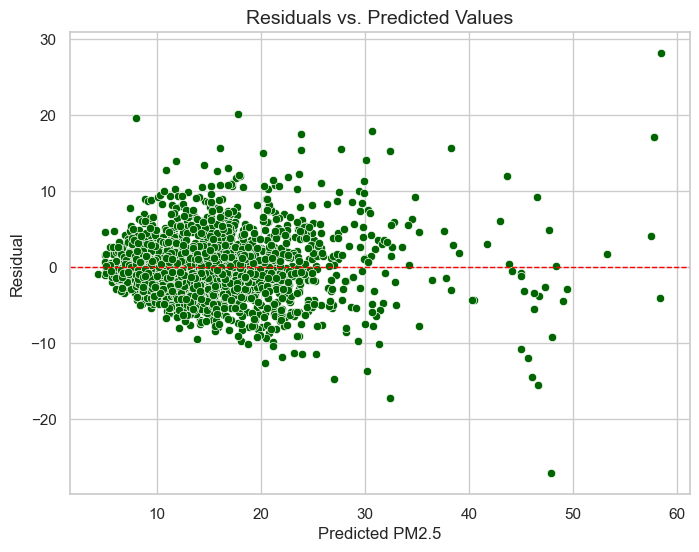

In [59]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Create a Residual column
df_reg['Residual'] = df_reg['Actual'] - df_reg['Predicted']

# 2. Summary statistics of the Residuals
res_mean = df_reg['Residual'].mean()
res_std = df_reg['Residual'].std()
print("Residual Mean:", res_mean)
print("Residual Std Dev:", res_std)

# 3. Distribution (Histogram + KDE) of Residuals
plt.figure(figsize=(8,6))
sns.histplot(df_reg['Residual'], kde=True, color='navy')
plt.title("Histogram & KDE of Residuals", fontsize=14)
plt.xlabel("Residual", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# 4. Q-Q Plot of Residuals (to check normality assumption)
plt.figure(figsize=(6,6))
stats.probplot(df_reg['Residual'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals", fontsize=14)
plt.show()

# 5. Residuals vs. Predicted Plot (to check homoscedasticity)
plt.figure(figsize=(8,6))
sns.scatterplot(x='Predicted', y='Residual', data=df_reg, color='darkgreen')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs. Predicted Values", fontsize=14)
plt.xlabel("Predicted PM2.5", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.show()